# Chapter 3: Exercises Solutions

1. In the method of separation of variables for the wave equation (see the lecture notes for Chapter 3), consider the cases $\lambda > 0$ and $\lambda = 0$.


Recall the boundary / initial value problem for the wave equation
$$
u_{tt} = u_{xx}, \qquad t > 0, \qquad -1 < x < 1, \qquad u(\pm 1, t) = 0,
$$
subject to the initial data
$$
u(x,0) = f(x), \qquad u_t(x,0) = g(x), \qquad x \in [-1, 1],
$$
where we assume that $f$ and $g$ are not both identically zero (because then the trivial solution $u(x,t) = 0$ solves the problem).

We showed in the lecture notes that the zero boundary conditions imply that $X(-1) = 0 = X(1)$.

If $\lambda > 0$, then
$$
X = c_1\cosh(\sqrt{\lambda}x) + c_2\sinh(\sqrt{\lambda}x)
$$
where $c_1$ and $c_2$ are arbitrary constants.  We require
$$
X(-1) = c_1\cosh(\sqrt{\lambda}) - c_2\sinh(\sqrt{\lambda}) = 0 =  c_1\cosh(\sqrt{\lambda}) + c_2\sinh(\sqrt{\lambda}).
$$
These equations can only be satisfied for $\lambda > 0$ if $c_1 = c_2 = 0$ (Why? See ($\star$) below).  Hence $X(x) = 0$ for $x \in [-1, 1]$ which implies that $u(x,t) = X(x)T(t) = 0$ for $t > 0$, however $u(x,0) = f(x)$ and $u_t(x,0) = g(x)$ and $f$ and $g$ are not both identically zero.   We conclude that there does not exist a continuous solution to the wave equation if $\lambda > 0$.

($\star$) Formulate the equations as a linear system, then 
$$
\begin{bmatrix}
\cosh(\sqrt{\lambda}) & -\sinh(\sqrt{\lambda}) \\
\cosh(\sqrt{\lambda}) & \sinh(\sqrt{\lambda})
\end{bmatrix}
\begin{bmatrix}
c_1 \\
c_2
\end{bmatrix} = 
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$
and it follows that $c_1 = c_2 = 0$ because the matrix is invertible; alternatively, it follows  that $c_1 = c_2 = 0$  since  $\sinh (\sqrt{\lambda})$ and $\cosh(\sqrt{\lambda})$ are linearly independent functions for $\lambda > 0$ (this can be seen, for example, by calculating the [Wronkskian](https://en.wikipedia.org/wiki/Wronskian)).

If $\lambda = 0$, then
$$
X(x) = c_1x + c_0
$$
and we require 
$$
X(-1) = c_0 - c_1 = 0 = c_0 + c_1
$$
which implies that $c_1 = c_2 = 0$.   Hence $X(x) = 0$ for $x \in [-1, 1]$ which implies that $u(x,t) = X(x)T(t) = 0$ for $t > 0$, however $u(x,0) = f(x)$ and $u_t(x,0) = g(x)$ and $f$ and $g$ are not both identically zero.   We conclude that there does not exist a continuous solution to the wave equation if $\lambda = 0$.

2. We showed, using the method of separation of variables, that 
$$
     u(x,t) =  \left( \sin\pi t + \cos\pi t  \right)\sin \pi x
$$
   is a solution to the wave equation with zero boundary conditions.  Use this solution to the wave equation to investigate the accuracy of the  numerical method discussed in the notes, i.e., 
$$
   \mathbf{u}^{i+1} = 2\mathbf{u}^{i} - \mathbf{u}^{i-1} + \tau^2 D_n^2\mathbf{u}^{i}, \qquad i = 0, \ldots, n_t-1.
$$
   Let $\tau = 8/n_x^2$ and $n_t \tau = 2$, compute the maximum error of the method for $n_x = 2^3, 2^4, \ldots, 2^8$, plot it on a log-log scale and deduce the rate of decay of the error with $n_x$.

In [1]:
using Plots, LinearAlgebra, FFTW

Here is a plot of the solution:

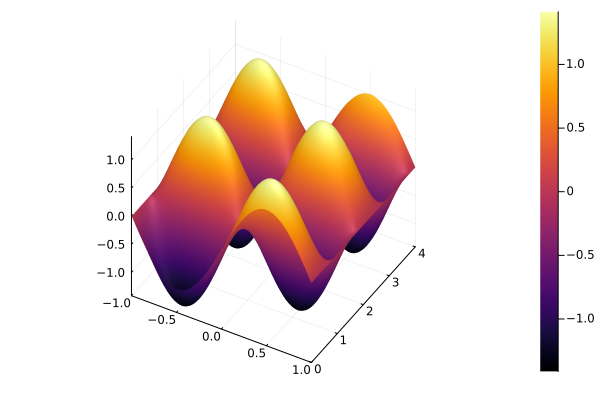

In [2]:
u(x,t) =  (sin(π*t) + cos(π*t))*sin(π*x)
x = range(-1,1,length=101)
t = range(0,4,length=101)
surface(x,t,u, camera=(30,40))

In [3]:
function chebfft(f)
    n = length(f)-1
    x = cos.((0:n)*π/n) # Chebyshev points
    ii = 0:n-1
    q = [f; f[n:-1:2]]      # transform x -> θ    
    # differentiate the interpolant qₙ in coefficient space and map back to function values
    cq = real.(fft(q))
    dq = real.(ifft(im*[ii; 0; 1-n:-1] .*cq))
    df = zeros(n+1,1)
    # Compute approximations to f' at the interior points
    df[2:n] = -dq[2:n] ./sqrt.(1 .- x[2:n].^2)    # transform θ -> x   
    # At the boundary points
    df[1] = sum(ii.^2 .*cq[1:n])/n + .5*n*cq[n+1]     
    df[n+1] = sum((-1) .^(ii .+1) .* ii.^2 .*cq[1:n])/n +
              .5*(-1)^(n+1)*n*cq[n+1]
    df
end

chebfft (generic function with 1 method)

First plot the error for on $t \in [0,2]$ to check that the method works as expected:

In [4]:
nx = 32 # should be even because chebfft only works with even inputs
x = cos.(π*(0:nx)/nx)
τ = 8/nx^2  # will see later why we choose this step size
u(x,t) =  (sin(π*t) + cos(π*t))*sin(π*x) # exact solution
v = u.(x,0) 
vold = u.(x,-τ)
tmax = 4 
nt = Int64(round(tmax/τ))
error = zeros(nt)
for i = 1:nt
    global v
    global vold
    w = chebfft(chebfft(v))  # second spatial derivative via FFT
    # zero boundary conditions
    w[1]=0; w[nx+1] = 0
    # Leapfrog method
    vnew = 2*v - vold + τ^2*w 
    # update
    vold = v; v = vnew
    # compute error
    error[i] = norm((v - u.(x,τ*i)),Inf)
end

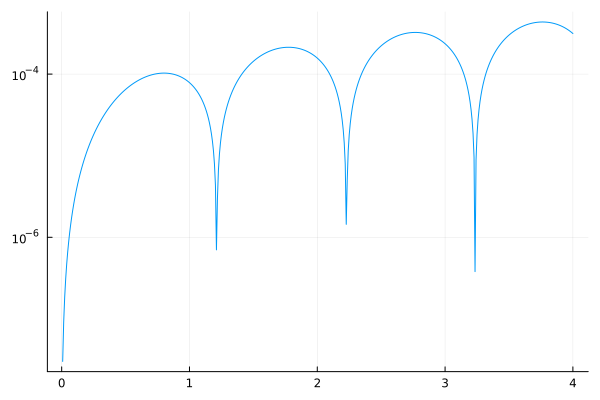

In [5]:
plot(τ*(1:nt),error;yscale=:log10,label=false)

In [6]:
Nv = 2 .^(3:8)
tmax = 2 
maxerr = []
for nx = Nv
    x = cos.(π*(0:nx)/nx)
    τ = 8/nx^2  # will see later why we choose this step size
    v = u.(x,0) 
    vold = u.(x,-τ)
    nt = @show Int64(round(tmax/τ))
    error = zeros(nt)
@time begin
    for i = 1:nt
        #global x, τ, v, vold
        w = chebfft(chebfft(v))  # second spatial derivative via FFT
        # zero boundary conditions
        w[1]=0; w[nx+1] = 0
        # Leapfrog method
        vnew = 2*v - vold + τ^2*w 
        # update
        vold = v; v = vnew
        # compute error
        error[i] = norm((v - u.(x,τ*i)),Inf)
    end
    end
    push!(maxerr,norm(error,Inf))
end

Int64(round(tmax / τ)) = 16
  0.001026 seconds (4.13 k allocations: 308.719 KiB)
Int64(round(tmax / τ)) = 64
  0.005325 seconds (16.51 k allocations: 1.534 MiB)
Int64(round(tmax / τ)) = 256
  0.034952 seconds (66.05 k allocations: 8.800 MiB)
Int64(round(tmax / τ)) = 1024
  0.203997 seconds (265.22 k allocations: 56.718 MiB, 15.20% gc time)
Int64(round(tmax / τ)) = 4096
  0.936644 seconds (1.06 M allocations: 396.921 MiB, 11.88% gc time)
Int64(round(tmax / τ)) = 16384
  5.123681 seconds (4.26 M allocations: 2.900 GiB, 12.24% gc time)


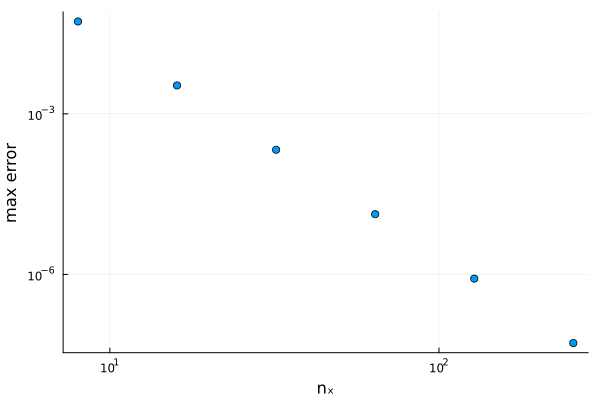

In [7]:
scatter(Nv,maxerr;yscale=:log10,xscale=:log10,xlabel="nₓ",ylabel="max error",label=false)

To estimate the rate of decay of the error, we estimate the slope of the line through the points (using least squares fitting, for example). Here, is a simple estimate: 

In [8]:
(log(maxerr[end])-log(maxerr[end-2]))/(log(Nv[end]) - log(Nv[end-2]))

-3.999623238274797

This suggests the error decays at the rate $\mathcal{O}(n_x^{-4})$ as $n_x \to \infty$.